In [1]:
# -*- coding: utf-8 -*-

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant
import json
import pandas as pd

Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'data')
MAX_SEQUENCE_LENGTH = 800
MAX_NUM_WORDS = 500000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [139]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))



Indexing word vectors.
Found 400001 word vectors.


In [152]:
from keras.datasets import imdb
#a = (x_train, y_train), b = (x_test, y_test)
a,b = imdb.load_data(path="imdb.npz",
                     num_words=None,
                     skip_top=10,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     seed=113,
                     start_char=1,
                     oov_char=2,
                     index_from=3)

x_train = a[0]
y_train = a[1]
x_test = b[0]
y_test = b[1]

word_index = imdb.get_word_index()

In [153]:
len(word_index)

88584

(array([ 454., 1826., 3691., 5577., 3504., 2246., 1696., 1250., 1000.,
         773.,  633.,  509.,  418.,  328.,  287.,  227.,  172.,  155.,
         140.,  114.]),
 array([  9. ,  48.5,  88. , 127.5, 167. , 206.5, 246. , 285.5, 325. ,
        364.5, 404. , 443.5, 483. , 522.5, 562. , 601.5, 641. , 680.5,
        720. , 759.5, 799. ]),
 <a list of 20 Patch objects>)

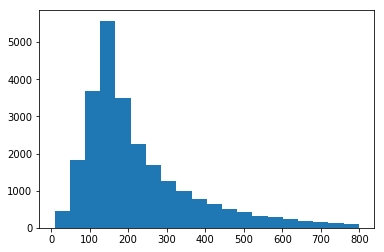

In [154]:
#plot the lengths distribution when the max len set as 1000

from matplotlib import pyplot as plt

p_lengths = []
for p in x_train:
    p_lengths.append(len(p))

plt.hist(p_lengths,bins=20)

In [155]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (25000, 800)
Shape of label tensor: (25000, 2)


In [156]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 4
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [157]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [158]:
model = Sequential()
model.add(embedding_layer)
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 800, 100)          8858800   
_________________________________________________________________
global_average_pooling1d_9 ( (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 34        
Total params: 8,860,450
Trainable params: 1,650
Non-trainable params: 8,858,800
_________________________________________________________________


In [159]:
len(word_index)

88584

In [160]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 24067 samples
Epoch 1/10
25000/25000 [==============================] - 12s 482us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 2/10
25000/25000 [==============================] - 9s 360us/step - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 3/10
25000/25000 [==============================] - 9s 356us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 4/10
25000/25000 [==============================] - 9s 374us/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 5/10
25000/25000 [==============================] - 10s 402us/step - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 6/10
25000/25000 [==============================] - 9s 367us/step - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 7/10
25000/25000 [==============================] - 9s 378us/step - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6932 

In [ ]:
model.save('EX2_WordEmbedding_trained_model')

In [161]:
# second, prepare text samples and their labels
print('Processing text dataset')

transcripts_x = []
transcripts_y = []

file_list = os.listdir('data')
for file in file_list:
    with open('data/' + file, 'r') as f:
        transcripts = json.load(f)
        transcripts_x.extend(transcripts['text'].values())
        transcripts_y.extend(transcripts['sentiment'].values())
        
#build a pandas df and drop all neutral rows
d = {'review': transcripts_x, 'label': transcripts_y}
df_transcripts = pd.DataFrame(data=d)

#drop all neutral rows
df_transcripts = df_transcripts[df_transcripts['label'] != 'neutral']

#replace positive and negative to pos and neg
df_transcripts['label'] = df_transcripts['label'].str.replace('positive','1')
df_transcripts['label'] = df_transcripts['label'].str.replace('negative','0')

transcripts_x = df_transcripts['review'].tolist()
transcripts_y = df_transcripts['label'].astype('int32').tolist()

Processing text dataset


In [162]:
transcripts_x[2]

"I'll just remind you that the units – those do not count in our unit totals nor do the units from Whole Foods Market. So, yeah, I would say essentially with that backdrop, we're still very, very encouraged by the demand and the reception from customers on the consumer side. We have Amazon fulfilled units are still growing faster than paid units. 3P is now up to 53% of total paid units."

In [163]:
def my_tokenize(text):
    tokens = text_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
    return tokens

In [164]:
transcripts_x_tokens = []
for t in transcripts_x:
    transcripts_x_tokens.append(my_tokenize(t))

In [165]:
transcripts_x_index = []
for t_tokens in transcripts_x_tokens:
    t_index = []
    for t in t_tokens:
        #get index from word_index for current token
        try:
            i = word_index[t] 
        except KeyError:
            i = 0
        t_index.append(i)
    transcripts_x_index.append(t_index)

In [166]:
transcripts_x_index = pad_sequences(transcripts_x_index, maxlen=MAX_SEQUENCE_LENGTH)
transcripts_y = to_categorical(np.asarray(transcripts_y))

In [167]:
print('Shape of data tensor:', transcripts_x_index.shape)
print('Shape of label tensor:', transcripts_y.shape)

Shape of data tensor: (379, 800)
Shape of label tensor: (379, 2)


In [168]:
# Predicting the Test set results
y_prob = model.predict(transcripts_x_index)
y_classes = y_prob.argmax(axis=-1)

In [169]:
labels_index_2 = {0:'negative',1:'positive',2:'neutral'} 
def pred_vec_to_lebal(vecs,labels_index_2):
    indices = [np.where(r==1)[0][0] for r in vecs]
    labels = [labels_index_2[i] for i in indices]
    return labels

In [171]:
y_val_labels = pred_vec_to_lebal(transcripts_y,labels_index_2)
y_classes_labels = pred_vec_to_lebal(y_classes,labels_index_2)

In [172]:
from nltk.metrics import ConfusionMatrix
print(ConfusionMatrix(y_val_labels, y_classes_labels))

         |   n   p |
         |   e   o |
         |   g   s |
         |   a   i |
         |   t   t |
         |   i   i |
         |   v   v |
         |   e   e |
---------+---------+
negative | <62>  . |
positive | 317  <.>|
---------+---------+
(row = reference; col = test)

